# Проект 1 трека CV инженер курса профессия Data Scince.

### Цель: Обучить модель нейронной сети распознаванию изображений лиц 5 известных IT бизнесменов
### Задачи: 
- Загрузить данные 
- Подготовить предварительную трансформацию исходных изображений для передачи в модель
- Обучить модель на обучающеф выборке
- Визуализировать результаты
- Сделать выводы по полученным результатам 

In [1]:
# необходимые библиотеки
%matplotlib inline

import os
import random
import warnings
warnings.filterwarnings("ignore") # Отключим отображение warning`ов.

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from copy import copy
import os
from PIL import Image
import math

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models

# Отобразим используемые версии torch и torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


In [2]:
# Функция для фиксации random seed для воспроизводимости результатов
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(1)

Теперь посмотрим на имеющиеся данные для обучения - они расположены в каталоге data

In [3]:
# Отобразим структуру каталога с данными
!ls data/

train  valid


Итак данные уже предварительно разбиты на каталоги с обучающей и валидационными выборками  
Теперь отобразим их внутреннее содержимое

In [4]:
!ls data/train/
!ls data/valid/

bill_gates  elon_musk  jeff_bezos  mark_zuckerberg  steve_jobs
bill_gates  elon_musk  jeff_bezos  mark_zuckerberg  steve_jobs


Структура папок в valid и train одинакова и содержит каталоги с изображениями бизнесменов  
Теперь посмотрим сколько изображений каждого из бизнесменов есть в данных

In [5]:
train_dict = dict()
valid_dict = dict()
for f in os.walk('data/'):
    path_list = f[0].split('/')
    if len(path_list)>1:
        if len(path_list)>2:
            for _ in f[2]:
                if path_list[1] == 'train':
                    train_dict[path_list[2]] = len(f[2])
                else:
                    valid_dict[path_list[2]] = len(f[2])

print('Trian group counts {}'.format(train_dict))
print('Valid group counts {}'.format(valid_dict))

Trian group counts {'jeff_bezos': 600, 'steve_jobs': 600, 'mark_zuckerberg': 600, 'elon_musk': 600, 'bill_gates': 600}
Valid group counts {'jeff_bezos': 214, 'steve_jobs': 66, 'mark_zuckerberg': 217, 'elon_musk': 194, 'bill_gates': 223}


Итак, в тренировочноый выборке всего 3000 изображений по 600 каждого из 5 классов, в валидационной выборке околоо 920 изображений.  
Размер пакета возьмем равным 10, так будет ровно 300 итераций по обучающей выборке

In [6]:
BATCH_SIZE = 10

Сформируем тренировочный и валидационный датасеты. В качестве загрузчика используем класс ImageFolder из пакета torchvision.datasets

In [7]:
train_dataset = ImageFolder("data/train/")
valid_dataset = ImageFolder("data/valid/")

Посмотрим корректно ли подгружаются данные

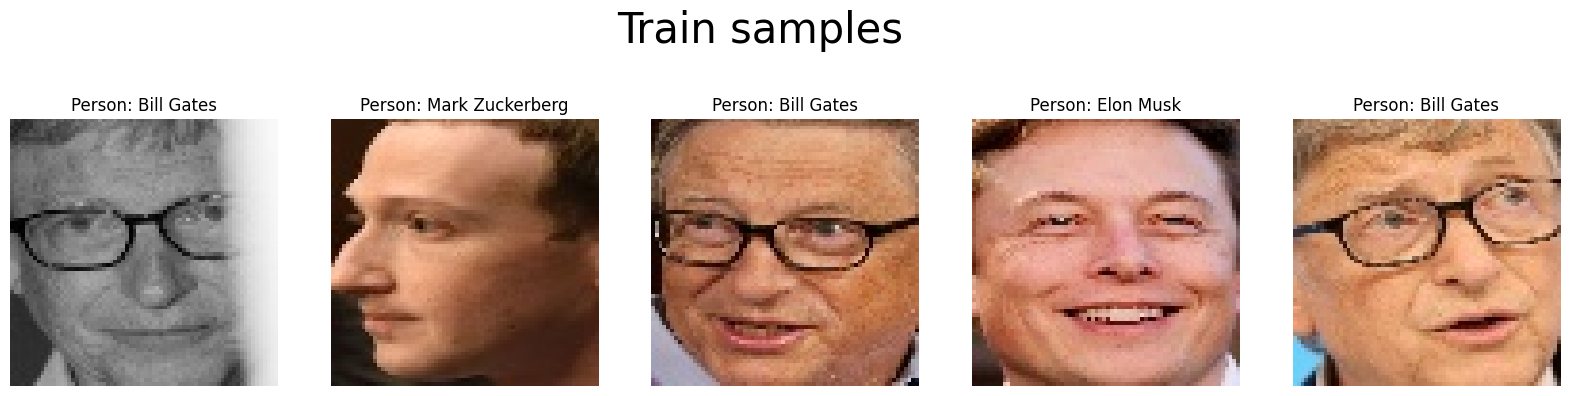

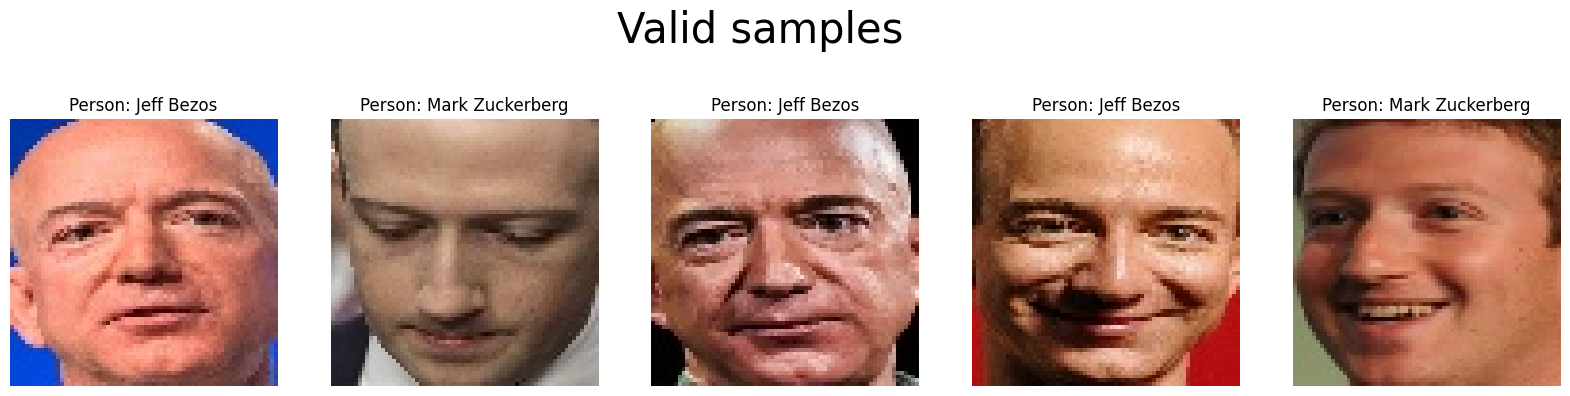

In [8]:
import random

def plot_samples(dataset, num_samples=5, title=None):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    fig.suptitle(title + ' samples', fontsize=30)
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Person: " + random_label.replace("_", " ").title())
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset, title = 'Train')
plot_samples(valid_dataset, title = 'Valid')

Данные загружаются верно


Теперь зададим преобразование изображений перед подачей в модель

In [9]:
# зададим нормализацию
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# в тренировочной выборке используем случайную вырезку из изображения,
# совмещенную с подгонкой размера, затем случайный горизонтальный переворот и преобразование в тензор
train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
# для валидационной выборки зададим только подгонку изображения
# и вырезание центрального кропа для соответствия размеров входному каналу сети, 
# ну и преобразуем изображение в тензор
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

Теперь передадим датасеты в DataLoader`ы

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

Для классификации возмем предобученную модель ResNet50 с готовыми весами после обучения на ImageNet и заменим последний полносвязный слой, для остальных слоев заморозим веса. Т.к. размер нашей обучающей выборки невелик.

In [11]:
# загрузим предобученную модель
net = models.resnet50(pretrained=True)
# заморозим веса
for parameter in net.parameters():
    parameter.requres_grad = False
# переопределим последний слой
net.fc = torch.nn.Linear(2048, len(train_dataset.classes))

Теперь зададим функцию ошибки и оптимизатор

In [12]:
# В качестве ошибки будем использовать кросс энтропию
criterion = torch.nn.CrossEntropyLoss()

In [13]:
# оптимизатором возьмем обычный стохастический градиентный спуск, для начала определим learning rate в 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

По возможности перенесем все вычисления на графический ускоритель

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)
criterion = criterion.to(device)

cuda


Отлично, графический ускоритель оказался доступен.  

Теперь определим функию для тренировки на шей модели

In [15]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []
    errors_valid = []
    
    for epoch in range(num_epochs):
        # начало эпохи
        print('EPOCH number: {}'.format(epoch + 1))
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []
        
        # цикл обучения, для визуализации процесса используем tqdm
        for i, (images, target) in enumerate(tqdm(train_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []
        erros = []
        
        # цикл валидации
        for i, (images, target) in enumerate(tqdm(valid_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])
            
            # также для понимания внутреенних процессов будем запоминать те изображения,
            # на которых модель ошибалась на валидации
            for out, targ, im in zip(output.argmax(1), target, images):
                if out != targ:
                    erros.append([out, targ, im])
            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))
        errors_valid = erros # ошибочные изображения будем запоминать только для последнего слоя
        print(f'Train loss: {round(loss_train[-1], 4)}, train acc: {round(top1_train[-1], 4)}, valid_loss: {round(loss_valid[-1], 4)}, valid_acc: {round(top1_valid[-1], 4)}')

    return loss_train, top1_train, loss_valid, top1_valid, errors_valid

Приступим к обучению, для начала пройдем 10 эпох

In [16]:
loss_train, top1_train, loss_valid, top1_valid, errors_valid = train_model(net, optimizer, train_dataset, valid_dataset, 10)

EPOCH number: 1


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.52it/s]


Train loss: 0.8433, train acc: 0.6663, valid_loss: 0.2487, valid_acc: 0.9125
EPOCH number: 2


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.49it/s]


Train loss: 0.4262, train acc: 0.8413, valid_loss: 0.0564, valid_acc: 0.9836
EPOCH number: 3


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.53it/s]


Train loss: 0.3266, train acc: 0.878, valid_loss: 0.0666, valid_acc: 0.9814
EPOCH number: 4


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.51it/s]


Train loss: 0.2805, train acc: 0.9017, valid_loss: 0.0744, valid_acc: 0.9737
EPOCH number: 5


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.45it/s]


Train loss: 0.2376, train acc: 0.9163, valid_loss: 0.0489, valid_acc: 0.9891
EPOCH number: 6


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.40it/s]


Train loss: 0.2063, train acc: 0.935, valid_loss: 0.0471, valid_acc: 0.9836
EPOCH number: 7


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.61it/s]


Train loss: 0.1879, train acc: 0.9367, valid_loss: 0.0286, valid_acc: 0.9923
EPOCH number: 8


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.57it/s]


Train loss: 0.179, train acc: 0.937, valid_loss: 0.0403, valid_acc: 0.9869
EPOCH number: 9


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.58it/s]


Train loss: 0.1782, train acc: 0.941, valid_loss: 0.0443, valid_acc: 0.9825
EPOCH number: 10


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.58it/s]

Train loss: 0.1641, train acc: 0.943, valid_loss: 0.0182, valid_acc: 0.9967


Построим графики кривых обучения и точности нашей модели на валидации и на обучении

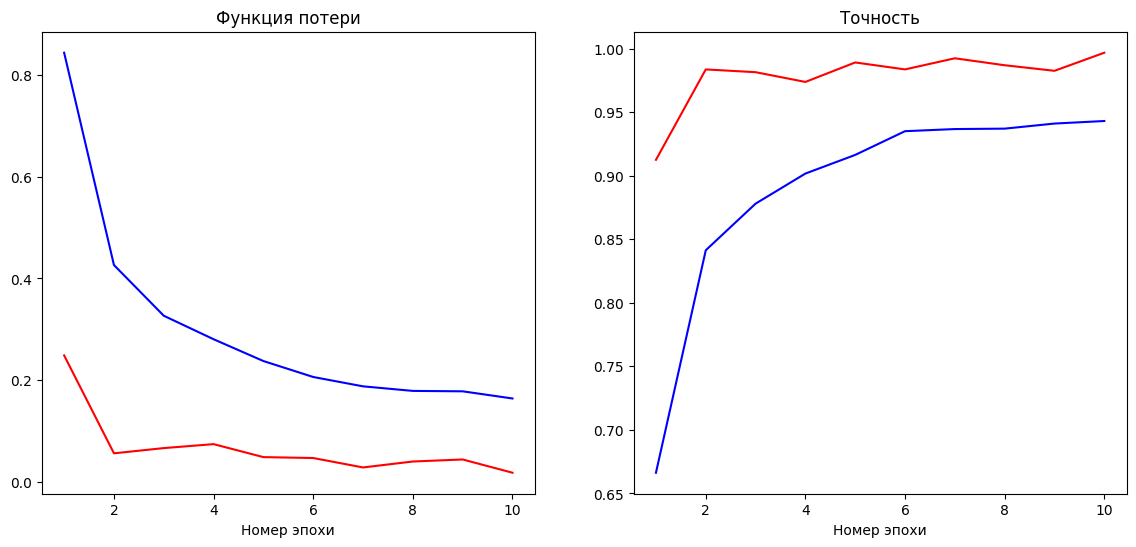

In [17]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b", label = 'Train')
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r", label = 'Valid')
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b", label = 'Train')
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r", label = 'Valid')
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

Итак, после 10 эпох точность на валидации оказалась в районе 99%, а ошибка около 0.02. Неплохой результат. То что показатели на тренировочной выборке хуже чем на валидационной объсняется во первых тем, что на тренировочном датасете используется альбументация, во-вторых - при тренировки модели активируются слои dropuot - которые вносят шум в данных, а также тем, что используется среднее значение за все батчи (это играет роль в первых эпохах).

Теперь посмотрим какие изображения не смогла узнать модель.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


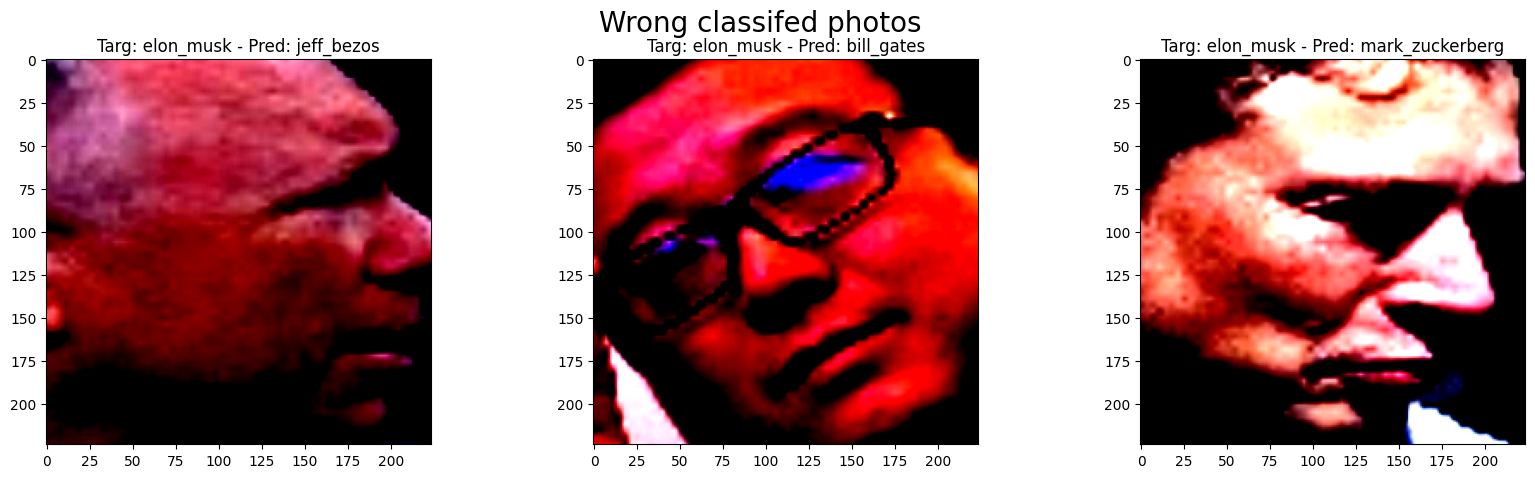

In [18]:
# функция для отображения изображений из errors_valid
def show_errors(errors):
    num_rows = math.ceil(len(errors)/5)
    if num_rows>1:
        fig, ax = plt.subplots(num_rows, 5, figsize = (20, num_rows*5))
        for i, item in enumerate(errors):
            im = item[2].to('cpu').permute(1, 2, 0)
            ax[i//5][i%5].imshow(im)
            ax[i//5][i%5].set_title(f'Targ: {train_dataset.classes[item[1]]} - Pred: {train_dataset.classes[item[0]]}')
    else:
        fig, ax = plt.subplots(1, len(errors), figsize = (20, 5))
        for i, item in enumerate(errors):
            im = item[2].to('cpu').permute(1, 2, 0)
            ax[i].imshow(im)
            ax[i].set_title(f'Targ: {train_dataset.classes[item[1]]} - Pred: {train_dataset.classes[item[0]]}')
    fig.suptitle('Wrong classifed photos', fontsize = 20)

show_errors(errors_valid)

Модель не смогла узнать 3 изображения, на всех из которых, согласно меткам, изображен Илон Маск. Однако, из них Маска можно узнать только на 3й, остальные две больше напоминают кадры из фильма ужасов, чем фото реальных людей.

Попробуем дообучить модель так, чтобы она смогла узнать и 3-е изображение (узнать Маска на первых двух изображениях не сможет наверное даже сам Илон).

Поскольку кривая обучения вышла на плато, для последующих эпох уменьшим learning rate на порядок.

In [19]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, weight_decay=1e-3)

In [20]:
loss_train, top1_train, loss_valid, top1_valid, errors_valid = train_model(net, optimizer, train_dataset, valid_dataset, 10)

EPOCH number: 1


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 13.76it/s]


Train loss: 0.1457, train acc: 0.949, valid_loss: 0.0171, valid_acc: 0.9956
EPOCH number: 2


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.53it/s]


Train loss: 0.1318, train acc: 0.954, valid_loss: 0.0151, valid_acc: 0.9978
EPOCH number: 3


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.51it/s]


Train loss: 0.1245, train acc: 0.9607, valid_loss: 0.0181, valid_acc: 0.9967
EPOCH number: 4


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.54it/s]


Train loss: 0.1258, train acc: 0.9577, valid_loss: 0.0181, valid_acc: 0.9967
EPOCH number: 5


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.54it/s]


Train loss: 0.1129, train acc: 0.965, valid_loss: 0.0172, valid_acc: 0.9978
EPOCH number: 6


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.49it/s]


Train loss: 0.1277, train acc: 0.955, valid_loss: 0.0147, valid_acc: 0.9967
EPOCH number: 7


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.57it/s]


Train loss: 0.1182, train acc: 0.96, valid_loss: 0.0198, valid_acc: 0.9967
EPOCH number: 8


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.58it/s]


Train loss: 0.1127, train acc: 0.9637, valid_loss: 0.0179, valid_acc: 0.9967
EPOCH number: 9


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.60it/s]


Train loss: 0.1079, train acc: 0.9657, valid_loss: 0.0154, valid_acc: 0.9978
EPOCH number: 10


100%|███████████████████████████████████████████| 92/92 [00:06<00:00, 14.29it/s]

Train loss: 0.1251, train acc: 0.9557, valid_loss: 0.0149, valid_acc: 0.9978


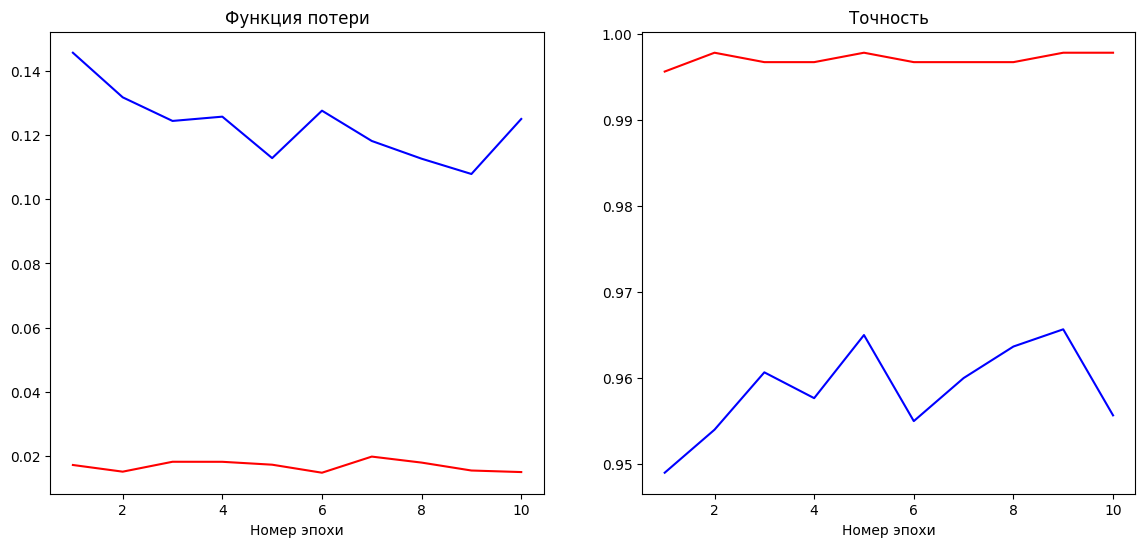

In [21]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b", label = 'Train')
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r", label = 'Valid')
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b", label = 'Train')
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r", label = 'Valid')
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

Итак, удалось еще немного увеличить качесто модели как на обучении так и на валидации. Теперь ошибка на валидации составляет 0.015, а accuracy 99.78%. Отличный результат!  
То, что на обучении кривая начала "скакать" может говорить о том, что модель выучила все возможные признаки которые в принципе может вычленить и теперь на метрику влияют только слои регуляризации.

Посматрим как с ошибочными изображениями

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


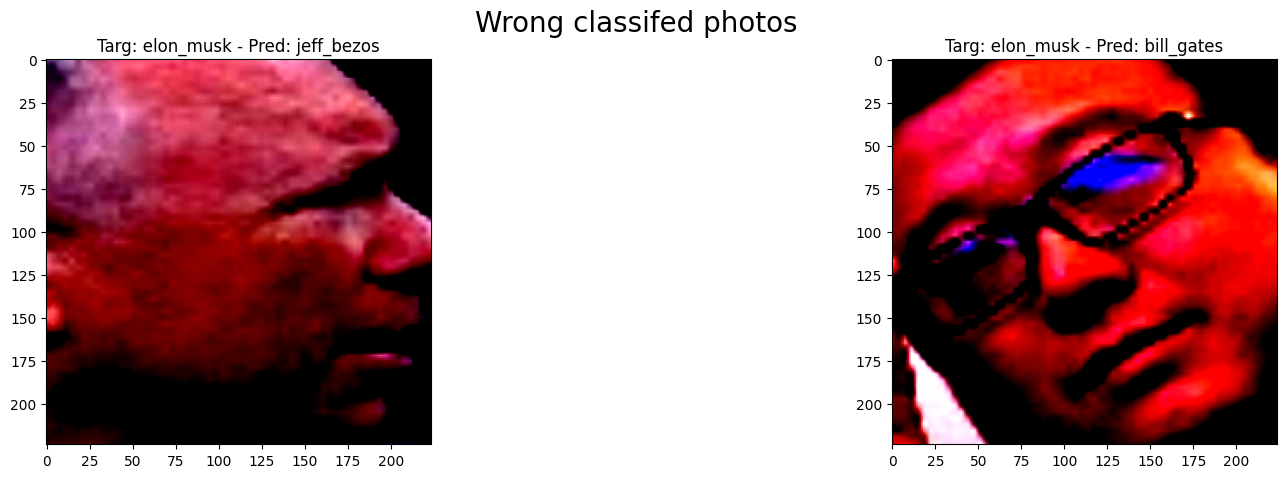

In [22]:
show_errors(errors_valid)

Осталось только те два неопознаваемых изображения!

Проверим нашу модель на микро тестовой выборке из 5 шаржевых изображений - по 1 на каждого бизнесмена

In [23]:
images = []
images.append(Image.open("test/bezos.jpg"))
images.append(Image.open("test/jobs.jpg"))
images.append(Image.open("test/mask.jpg"))
images.append(Image.open("test/gates.jpg"))
images.append(Image.open("test/zuckerberg.jpeg"))

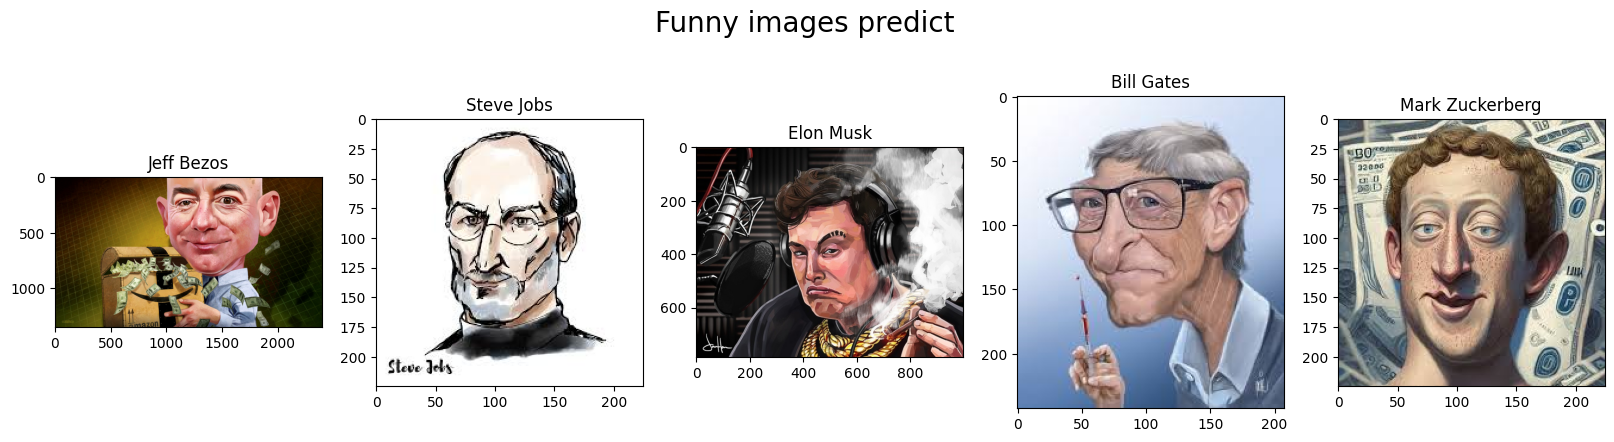

In [24]:
fig, ax = plt.subplots(1, 5, figsize = (20, 5))
fig.suptitle('Funny images predict', fontsize = 20)
for i in range(len(images)):
    ax[i].imshow(images[i])
    tensor = valid_dataset.transform(images[i])
    batch = torch.stack([tensor])
    with torch.no_grad():
        output = net(batch.to(device)).to("cpu")
    predicted = output.argmax().item()
    ax[i].set_title(train_dataset.classes[predicted].replace('_', ' ').title())

Все изображения распознаны верно, несмотря на то, что это не фотографии реальных людей, а шаржи с искаженными пропорциями.
Модель готова!